# Graph Example

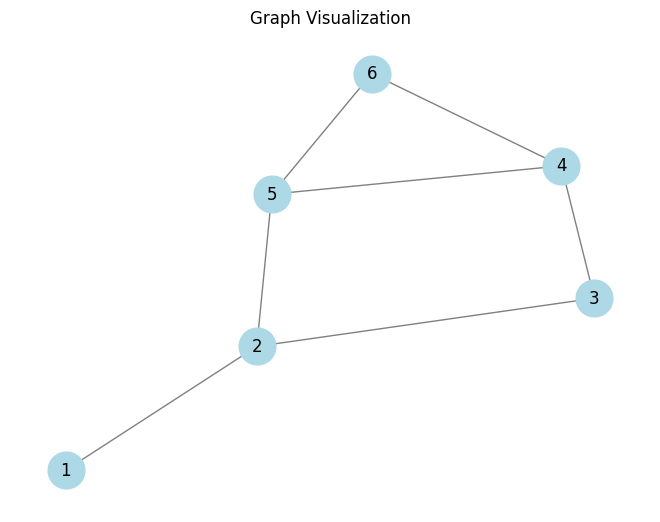

In [2]:
from typing import List, Tuple
import matplotlib.pyplot as plt
import networkx as nx
GRAPH = Tuple[List[int], List[Tuple[int, int]]]
V = list([1,2,3,4,5,6])
E = list([(1,2), (2,3), (3,4), (4,5), (5,6), (2,5), (4,6)])

G = (
    V,E
)

def plot_graph(G):
    G_nx = nx.Graph()
    G_nx.add_nodes_from(G[0])
    G_nx.add_edges_from(G[1])

    pos = nx.spring_layout(G_nx)
    nx.draw(G_nx, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=700)
    
    plt.title("Graph Visualization")
    plt.show()

plot_graph(G)

# Algo

## Observability rules

In [3]:
def R1(edge_set, G:GRAPH):
    """Given a set of edges, return a set of nodes observed in those edges."""
    assert edge_set.issubset(G[1]), "edge_set must be a subset of the edges E of G"
    if not isinstance(edge_set, set):
        raise TypeError("Input must be a set of edges.")
    set_of_nodes = set()
    for edge in edge_set:
        set_of_nodes.update(edge)
    return set_of_nodes

def propagate_R2(observed_nodes, G:GRAPH, verbode=False):
    """ 
    Updates the set of observed nodes using rule R2 and return the participating nodes.
    """
    assert observed_nodes.issubset(G[0]), "observed_nodes must be a subset of the nodes V of G"
    if not isinstance(observed_nodes, set):
        raise TypeError("Input must be a set of nodes.")
    participating_edges = set()
    for node in observed_nodes.copy():
        neighbors = set(n for n, m in G[1] if m == node) | set(m for n, m in G[1] if n == node)
        neighbors.discard(node)
        if len(neighbors-observed_nodes) == 1:
            if verbode:
                print(f"Node {node} has one neighbor unobserved: {neighbors - observed_nodes}")
            new_observed_nodes = (neighbors-observed_nodes).pop()
            observed_nodes.add(new_observed_nodes)
            participating_edges.add((node, new_observed_nodes))
    return participating_edges
        

def observability(edge_set, G:GRAPH):
    """Give observed nodes and participating nodes using the edge set provided."""
    observed_nodes = R1(edge_set, G)
    participating_edges = set()
    while True:
        nb_before_propagation = len(observed_nodes)
        new_participating_edges = propagate_R2(observed_nodes, G)
        participating_edges.update(new_participating_edges)
        nb_after_propagation = len(observed_nodes)
        if nb_after_propagation == nb_before_propagation:
            return observed_nodes, participating_edges

def is_observability_satisfied(observed_nodes, G:GRAPH):
    """Check if the observability condition is satisfied for the graph G."""
    return len(observed_nodes) == len(G[0])

observed_nodes, participating_edges = observability(set([(5,6)]), G)
print("Observed Nodes:", observed_nodes)
print("Participating Edges:", participating_edges)
print("Observability satisfied : ", is_observability_satisfied(observed_nodes, G))

Observed Nodes: {1, 2, 3, 4, 5, 6}
Participating Edges: {(4, 3), (2, 1), (6, 4), (5, 2)}
Observability satisfied :  True


## Model

### Master

In [8]:
from pyomo.environ import ConcreteModel, Var, Objective, Constraint, Binary, minimize, Set

def build_model(G):
    """Build a Pyomo model for the given graph G."""
    V, E = G
    model = ConcreteModel()
    model.V = Set(initialize=sorted(V))
    model.E = Set(initialize=sorted(E))
    model.s = Var(model.E, domain=Binary)

    def objective_rule(model):
        return sum(model.s[edge] for edge in model.E)
    model.objective = Objective(rule=objective_rule, sense=minimize)

    def symmetry_constraint_rule(model, i, j):
        if (j, i) in model.E:
            return model.s[(i, j)] == model.s[(j, i)]
        return Constraint.Skip
    model.symmetry_constraint = Constraint(model.E, rule=symmetry_constraint_rule)
    return model

def solve_model(model, solver_name='glpk'):
    """Solve the Pyomo model using the specified solver."""
    from pyomo.opt import SolverFactory
    solver = SolverFactory(solver_name)
    assert solver.available(), f"{solver_name} solver not available"
    results = solver.solve(model)
    sol = {f"{edge}": model.s[edge].value for edge in model.E}
    return sol, model.objective()

def sol_to_edgeset(solution:dict,E):
    """Convert a solution dictionary to a list of edges."""
    return set([E[i] for i, value in enumerate(solution.values()) if value > 0.5])

# Example usage:
# model = build_model(G)
# sol, objective = solve_model(model)
# print("soluction :", sol)
# print("edge edges :", sol_to_edgeset(sol,E))


### Cutting Planes

In [4]:
import random

def generate_cut(s:set, termination:int, G:GRAPH):
    E = set(G[1])
    termination = 0
    observed_nodes, participating_edges = observability(s, G)
    if is_observability_satisfied(observed_nodes, G):
        termination = 1
        alpha = [0]*len(G[1])
    else : 
        theta = observed_nodes
        while len(observed_nodes) != len(G[0]):
            v = random.choice(list(set(G[0]) - observed_nodes))
            # Find an edge (u, v) or (v, u) in E where u is already observed
            candidate_edges = [e for e in E if v in e and (e[0] in observed_nodes or e[1] in observed_nodes)]
            if candidate_edges:
                # Pick one such edge and add it to s
                new_edge = random.choice(candidate_edges)
                s = s | {new_edge}
                print(f"Adding edge {new_edge} to the set of edges s")
            observed_nodes, _ = observability(s, G)
            if is_observability_satisfied(observed_nodes, G) is False :
                theta = observed_nodes
                print("theta", theta)
        # Set of edges induced by theta (i.e., edges with both endpoints in theta)
        F = set(e for e in E if e[0] in theta and e[1] in theta)
        # alpha is a list indicating for each edge in sorted(E) if it is in E-F (1) or not (0)
        E_minus_F = E - F
        edge_list = sorted(E)
        alpha = [1 if edge in E_minus_F else 0 for edge in edge_list]
    return alpha, termination

print(generate_cut({(3, 4)}, 0, G))

Adding edge (4, 6) to the set of edges s
([1, 0, 1, 0, 1, 1, 1], 0)


In [5]:
from pyomo.environ import Constraint, ConstraintList

def add_alpha_constraint(model, alpha):
    # Initialize ConstraintList if not already done
    if not hasattr(model, 'alpha_constraints'):
        model.alpha_constraints = ConstraintList()

    edge_list = sorted(model.E)

    # Add the new constraint (cut) to the ConstraintList
    expr = sum(alpha[i] * model.s[edge_list[i]] for i in range(len(edge_list))) >= 1
    model.alpha_constraints.add(expr)


### Bilevel Solve

In [ ]:
def bilevel_solve(G):
    termination=0
    model = build_model(G)
    add_alpha_constraint(model, [1]*len(G[1]))  # Start with an empty alpha constraint
    sol, objective = solve_model(model)
    edge_set = sol_to_edgeset(sol, G[1])
    while termination == 0:
        print("Current edge set:", edge_set)
        alpha, termination = generate_cut(edge_set, termination, G)
        print("Generated alpha:", alpha)
        add_alpha_constraint(model, alpha)
        sol, objective = solve_model(model)
        edge_set = sol_to_edgeset(sol, G[1])
    return edge_set
print(bilevel_solve(G))

Current edge set: {(1, 2)}
theta {1, 2}
Adding edge (2, 3) to the set of edges s
Generated alpha: [0, 1, 1, 1, 1, 1, 1]
Current edge set: {(2, 3)}
Adding edge (4, 5) to the set of edges s
Generated alpha: [1, 0, 1, 0, 1, 1, 1]
Current edge set: {(3, 4)}
Adding edge (4, 6) to the set of edges s
Generated alpha: [1, 0, 1, 0, 1, 1, 1]
Current edge set: {(3, 4)}
Adding edge (2, 5) to the set of edges s
Generated alpha: [1, 0, 1, 0, 1, 1, 1]
Current edge set: {(3, 4)}
Adding edge (4, 6) to the set of edges s
Generated alpha: [1, 0, 1, 0, 1, 1, 1]
Current edge set: {(3, 4)}
Adding edge (1, 2) to the set of edges s
Generated alpha: [1, 0, 1, 0, 1, 1, 1]
Current edge set: {(3, 4)}
Adding edge (1, 2) to the set of edges s
Generated alpha: [1, 0, 1, 0, 1, 1, 1]
Current edge set: {(3, 4)}
Adding edge (1, 2) to the set of edges s
Generated alpha: [1, 0, 1, 0, 1, 1, 1]
Current edge set: {(3, 4)}
Adding edge (4, 6) to the set of edges s
Generated alpha: [1, 0, 1, 0, 1, 1, 1]
Current edge set: {(3, 4

KeyboardInterrupt: 